<a href="https://colab.research.google.com/github/igoravelli/brazilian_soccer_championship_analysis/blob/main/Win_frequency_in_home_matches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & configs

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

data_table.enable_dataframe_formatter()
auth.authenticate_user()

project = 'brasileirao-362523'
schema = 'exp_brasileirao'
location = 'US'

client = bigquery.Client(project=project, location=location)

In [6]:
# @title get dim_partida
dim_partida = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_dimPartida`
    """).to_dataframe()

dim_partida.set_index('pk_partida', inplace=True)
dim_partida.head()

,estadio,visitante,mandante,rodada,data_partida,ano_campeonato,formacao_mandante,formacao_visitante,vencedor,perdedor
pk_partida,,,,,,,,,,
1114,mane_garrincha,vasco,brasiliense,1,2005-04-24 18:10:00,2005,N/A,N/A,None,None
1148,boca_do_jacare,fluminense,brasiliense,4,2005-05-15 18:10:00,2005,N/A,N/A,fluminense,brasiliense
1167,boca_do_jacare,parana,brasiliense,6,2005-05-29 16:00:00,2005,N/A,N/A,brasiliense,parana
1183,mane_garrincha,corinthians,brasiliense,8,2005-06-18 16:00:00,2005,N/A,N/A,corinthians,brasiliense
1213,boca_do_jacare,athletico-pr,brasiliense,10,2005-07-03 18:10:00,2005,N/A,N/A,brasiliense,athletico-pr


# Transformations

In [13]:
# @title identify which match have home team as a winner
dim_partida['mandante_vencedor'] = dim_partida['vencedor'] == dim_partida['mandante']
dim_partida.head()

,estadio,visitante,mandante,rodada,data_partida,ano_campeonato,formacao_mandante,formacao_visitante,vencedor,perdedor,mandante_vencedor
pk_partida,,,,,,,,,,,
1114,mane_garrincha,vasco,brasiliense,1,2005-04-24 18:10:00,2005,N/A,N/A,None,None,False
1148,boca_do_jacare,fluminense,brasiliense,4,2005-05-15 18:10:00,2005,N/A,N/A,fluminense,brasiliense,False
1167,boca_do_jacare,parana,brasiliense,6,2005-05-29 16:00:00,2005,N/A,N/A,brasiliense,parana,True
1183,mane_garrincha,corinthians,brasiliense,8,2005-06-18 16:00:00,2005,N/A,N/A,corinthians,brasiliense,False
1213,boca_do_jacare,athletico-pr,brasiliense,10,2005-07-03 18:10:00,2005,N/A,N/A,brasiliense,athletico-pr,True


In [14]:
# @title identify which match was draw
dim_partida['foi_empate'] = dim_partida['vencedor'].isnull()

In [15]:
# @title modify the `mandante_vencedor` column when is a draw
dim_partida.loc[dim_partida.foi_empate, 'mandante_vencedor'] = 'empate'

# Visualizations

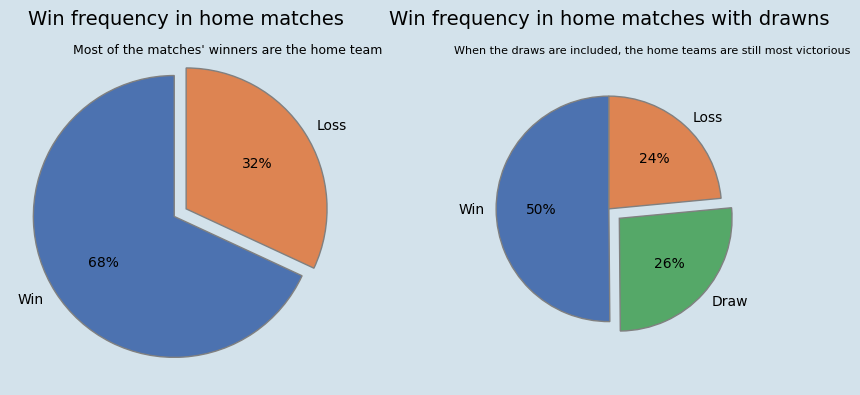

In [16]:
wo_drawns_matches = dim_partida.loc[~dim_partida['foi_empate']]

wo_drawns_data = wo_drawns_matches.mandante_vencedor.value_counts()
all_matches_data = dim_partida.mandante_vencedor.value_counts()


sns.set_palette('deep')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
fig.set_facecolor('#D3E2EB')

colors = sns.color_palette('deep')[0:4]

# primeira figura
ax1.pie(wo_drawns_data,
        labels=['Win','Loss'],
        startangle=90,
        explode=(0.1,0),
        autopct='%1.0f%%',
        colors=colors,
        wedgeprops={"edgecolor":"gray"},
        radius=1)

ax1.set_title('Win frequency in home matches', fontsize=14)
ax1.text(-0.8, 1.1, "Most of the matches' winners are the home team", fontsize=9)


# segunda figura
ax2.pie(all_matches_data,
        labels=['Win','Draw','Loss'],
        startangle=90,
        explode=(0,0.1,0),
        autopct='%1.0f%%',
        colors=[colors[0], colors[2], colors[1]],
        wedgeprops={"edgecolor":"gray"},
        radius=0.8)

ax2.set_title('Win frequency in home matches with drawns', fontsize=14)
ax2.text(-1.1, 1.1, 'When the draws are included, the home teams are still most victorious', fontsize=8)

plt.show()

# Conclusion

As we can see in the chart above, in most matches, precisely 68% of all matches with a winner, the winner is the home team.

We can explain this by the pressure made by the home public that forces its team to play harder and more advanced.

Even if we add the drawns, the landscape doesn't changes, where the home team wins 2x times more than the visitor teams.